In [1]:
from mitoolspro.regressions import regime_models
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
from datetime import datetime
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds, ogap, inf, areturns
import matplotlib.pyplot as plt

# Markov switching dynamic regression models from Statsmodels

https://www.statsmodels.org/stable/examples/notebooks/generated/markov_regression.html

This notebook provides an example of the use of Markov switching models in statsmodels to estimate dynamic regression models with changes in regime. It follows the examples in the Stata Markov switching documentation, which can be found at http://www.stata.com/manuals14/tsmswitch.pdf.

In [2]:
usrec = DataReader(
    "USREC", "fred", start=datetime(1947, 1, 1), end=datetime(2013, 4, 1)
)

## Federal funds rate with switching intercept

The first example models the federal funds rate as noise around a constant intercept, but where the intercept changes during different regimes. The model is simply: $$r_{t} = \mu_{S_t} + \varepsilon_{t}, \varepsilon_{t} \sim N(0, \sigma^2)$$

where $S_{t}\epsilon\left\{0,1 \right\}$, and the regime transitions according to $$P\left(S_{t} = s_{t} \mid S_{t-1} = s_{t-1} \right) = \begin{bmatrix}p_{00} & p_{10} \\1-p_{00} &  1 - p_{10} \\\end{bmatrix}$$

We will estimate the parameters of this model by maximum likelihood: $p_00, p_10, \mu_0, \mu_1, \sigma^2$.

The data used in this example can be found at https://www.stata-press.com/data/r14/usmacro.

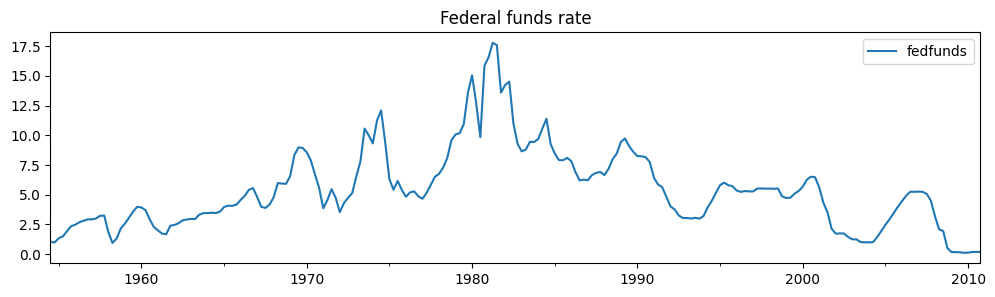

In [3]:
dta_fedfunds = pd.Series(
    fedfunds, index=pd.date_range("1954-07-01", "2010-10-01", freq="QS"), name="fedfunds"
).to_frame()
_ = dta_fedfunds.plot(title="Federal funds rate", figsize=(12, 3))

In [4]:
mod_fedfunds = regime_models.MarkovRegressionModel(data=dta_fedfunds, dependent_variable="fedfunds", k_regimes=2)
res_fedfunds = mod_fedfunds.fit()

In [5]:
res_fedfunds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  226
Model:               MarkovRegression   Log Likelihood                -508.636
Date:                Wed, 19 Mar 2025   AIC                           1027.272
Time:                        20:11:35   BIC                           1044.375
Sample:                             0   HQIC                          1034.174
                                - 226                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7088      0.177     20.988      0.000       3.362       4.055
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5568      0.300     31.857      0.000       8.969      10.145
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.4418      0.425     10.447      0.000       3.608       5.275
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9821      0.010     94.443      0.000       0.962       1.002
p[1->0]        0.0504      0.027      1.876      0.061      -0.002       0.103
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

From the summary output, the mean federal funds rate in the first regime (the “low regime”) is estimated to be $3.7$ whereas in the “high regime” it is $9.6$. Below we plot the smoothed probabilities of being in the high regime. The model suggests that the 1980’s was a time-period in which a high federal funds rate existed.

<Axes: title={'center': 'Probability of being in the high regime'}>

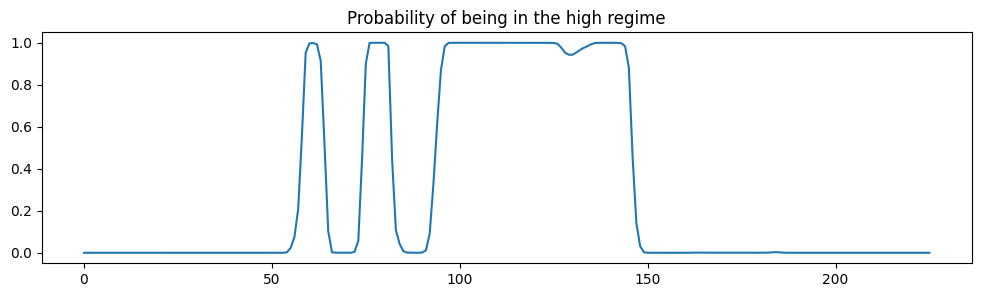

In [6]:
pd.DataFrame(res_fedfunds.smoothed_marginal_probabilities)[1].plot(
    title="Probability of being in the high regime", figsize=(12, 3)
)

From the estimated transition matrix we can calculate the expected duration of a low regime versus a high regime.

In [7]:
print(res_fedfunds.expected_durations)

[55.85400626 19.85506546]


A low regime is expected to persist for about fourteen years, whereas the high regime is expected to persist for only about five years.

### Federal funds rate with switching intercept and lagge dependent variable

The second example augments the previous model to include the lagged value of the federal funds rate.

$$r_{t} = \mu_{S_t} + \beta_{S_t} r_{t-1} + \varepsilon_{t}, \varepsilon_{t} \sim N(0, \sigma^2)$$
where $S_{t}\epsilon\left\{0,1 \right\}$, and the regime transitions according to $$P\left(S_{t} = s_{t} \mid S_{t-1} = s_{t-1} \right) = \begin{bmatrix}p_{00} & p_{10} \\1-p_{00} &  1 - p_{10} \\\end{bmatrix}$$
We will estimate the parameters of this model by maximum likelihood: 
$p_{00}, p_{10}, \mu_0, \mu_1,\beta_0, \beta_1, \sigma^2$.

In [8]:
dta_fedfunds['lfedfunds'] = dta_fedfunds['fedfunds'].shift(1)
mod_fedfunds2 = regime_models.MarkovRegressionModel(data=dta_fedfunds.iloc[1:], 
                                          dependent_variable="fedfunds", 
                                          k_regimes=2, 
                                          independent_variables=["lfedfunds"])
res_fedfunds2 = mod_fedfunds2.fit()

In [9]:
res_fedfunds2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               MarkovRegression   Log Likelihood                -264.711
Date:                Wed, 19 Mar 2025   AIC                            543.421
Time:                        20:11:50   BIC                            567.334
Sample:                             0   HQIC                           553.073
                                - 225                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7245      0.289      2.510      0.012       0.159       1.290
x1             0.7631      0.034     22.629      0.000       0.697       0.829
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0989      0.118     -0.835      0.404      -0.331       0.133
x1             1.0612      0.019     57.351      0.000       1.025       1.097
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4783      0.050      9.642      0.000       0.381       0.576
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6378      0.120      5.304      0.000       0.402       0.874
p[1->0]        0.1306      0.050      2.634      0.008       0.033       0.228
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

There are several things to notice from the summary output:

1. The information criteria have decreased substantially, indicating that this model has a better fit than the previous model.

2. The interpretation of the regimes, in terms of the intercept, have switched. Now the first regime has the higher intercept and the second regime has a lower intercept.

Examining the smoothed probabilities of the high regime state, we now see quite a bit more variability.

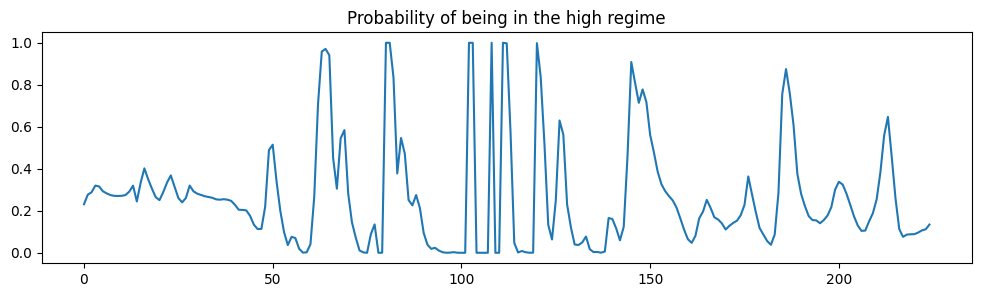

In [10]:
_ = pd.DataFrame(res_fedfunds2.smoothed_marginal_probabilities)[0].plot(
    title="Probability of being in the high regime", figsize=(12, 3)
)

Finally, the expected durations of each regime have decreased quite a bit.

In [11]:
print(res_fedfunds2.expected_durations)

[2.76105188 7.65529154]


### Taylor rule with 2 or 3 regimes

We now include two additional exogenous variables - a measure of the output gap and a measure of inflation - to estimate a switching Taylor-type rule with both 2 and 3 regimes to see which fits the data better.

Because the models can be often difficult to estimate, for the 3-regime model we employ a search over starting parameters to improve results, specifying 20 random search repetitions.

In [12]:
dta_ogap = pd.Series(ogap, index=pd.date_range("1954-07-01", "2010-10-01", freq="QS"), name="ogap")
dta_inf = pd.Series(inf, index=pd.date_range("1954-07-01", "2010-10-01", freq="QS"), name='inf')

dta_fedfunds_ogap_inf = pd.concat((dta_fedfunds, dta_ogap, dta_inf), axis=1).iloc[4:]

In [13]:
dta_fedfunds_ogap_inf

,fedfunds,lfedfunds,ogap,inf
1955-07-01,1.94,1.50,4.157602,-0.234724
1955-10-01,2.36,1.94,4.287756,0.373734
1956-01-01,2.48,2.36,3.016838,0.250065
1956-04-01,2.69,2.48,2.641856,1.046455
1956-07-01,2.81,2.69,1.824735,2.016656
...,...,...,...,...
2009-10-01,0.12,0.16,-6.894039,1.487498
2010-01-01,0.13,0.12,-6.830622,2.336871
2010-04-01,0.19,0.13,-6.265080,1.785890
2010-07-01,0.19,0.19,-5.932871,1.228732


In [14]:
mod_fedfunds3 = regime_models.MarkovRegressionModel(data=dta_fedfunds_ogap_inf, 
                                          dependent_variable="fedfunds", 
                                          k_regimes=2, 
                                          independent_variables=['lfedfunds', 'ogap', 'inf'])
res_fedfunds3 = mod_fedfunds3.fit()

In [15]:
np.random.seed(12345)
mod_fedfunds4 = regime_models.MarkovRegressionModel(data=dta_fedfunds_ogap_inf, 
                                          dependent_variable="fedfunds", 
                                          k_regimes=3, 
                                          independent_variables=['lfedfunds', 'ogap', 'inf'])
res_fedfunds4 = mod_fedfunds4.fit(search_reps=20)

/Users/sebastian/Desktop/MontagnaInc/Projects/miToolsPro/.venv/lib/python3.12/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
/Users/sebastian/Desktop/MontagnaInc/Projects/miToolsPro/.venv/lib/python3.12/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
/Users/sebastian/Desktop/MontagnaInc/Projects/miToolsPro/.venv/lib/python3.12/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.

In [16]:
res_fedfunds3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               MarkovRegression   Log Likelihood                -229.256
Date:                Wed, 19 Mar 2025   AIC                            480.512
Time:                        20:12:12   BIC                            517.942
Sample:                             0   HQIC                           495.624
                                - 222                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6555      0.137      4.771      0.000       0.386       0.925
x1            -0.0274      0.041     -0.671      0.502      -0.107       0.053
x2             0.8314      0.033     24.951      0.000       0.766       0.897
x3             0.1355      0.029      4.609      0.000       0.078       0.193
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0945      0.128     -0.739      0.460      -0.345       0.156
x1             0.2125      0.030      7.147      0.000       0.154       0.271
x2             0.9293      0.027     34.309      0.000       0.876       0.982
x3             0.0343      0.024      1.429      0.153      -0.013       0.081
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3323      0.035      9.526      0.000       0.264       0.401
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7279      0.093      7.828      0.000       0.546       0.910
p[1->0]        0.2115      0.064      3.298      0.001       0.086       0.337
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [17]:
res_fedfunds4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               MarkovRegression   Log Likelihood                -180.806
Date:                Wed, 19 Mar 2025   AIC                            399.611
Time:                        20:12:12   BIC                            464.262
Sample:                             0   HQIC                           425.713
                                - 222                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0259      0.087     -0.299      0.765      -0.196       0.144
x1             0.1215      0.022      5.607      0.000       0.079       0.164
x2             0.9737      0.019     50.302      0.000       0.936       1.012
x3             0.0341      0.017      2.033      0.042       0.001       0.067
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7346      0.130      5.636      0.000       0.479       0.990
x1            -0.0499      0.027     -1.835      0.066      -0.103       0.003
x2             0.8436      0.024     35.258      0.000       0.797       0.890
x3             0.1633      0.025      6.638      0.000       0.115       0.211
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0250      0.290     -3.532      0.000      -1.594      -0.456
x1             1.1381      0.081     13.977      0.000       0.978       1.298
x2             0.3277      0.086      3.812      0.000       0.159       0.496
x3             0.2036      0.049      4.154      0.000       0.108       0.300
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1660      0.018      9.247      0.000       0.131       0.201
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8259      0.000   5034.511      0.000       0.826       0.826
p[1->0]        0.2288      0.070      3.274      0.001       0.092       0.366
p[2->0]        0.1044      0.094      1.107      0.268      -0.080       0.289
p[0->1]        0.1741   7.53e-05   2311.610      0.000       0.174       0.174
p[1->1]        0.6929      0.080      8.656      0.000       0.536       0.850
p[2->1]        0.1742      0.113      1.547      0.122      -0.046       0.395
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differ

Due to lower information criteria, we might prefer the 3-state model, with an interpretation of low-, medium-, and high-interest rate regimes. The smoothed probabilities of each regime are plotted below.

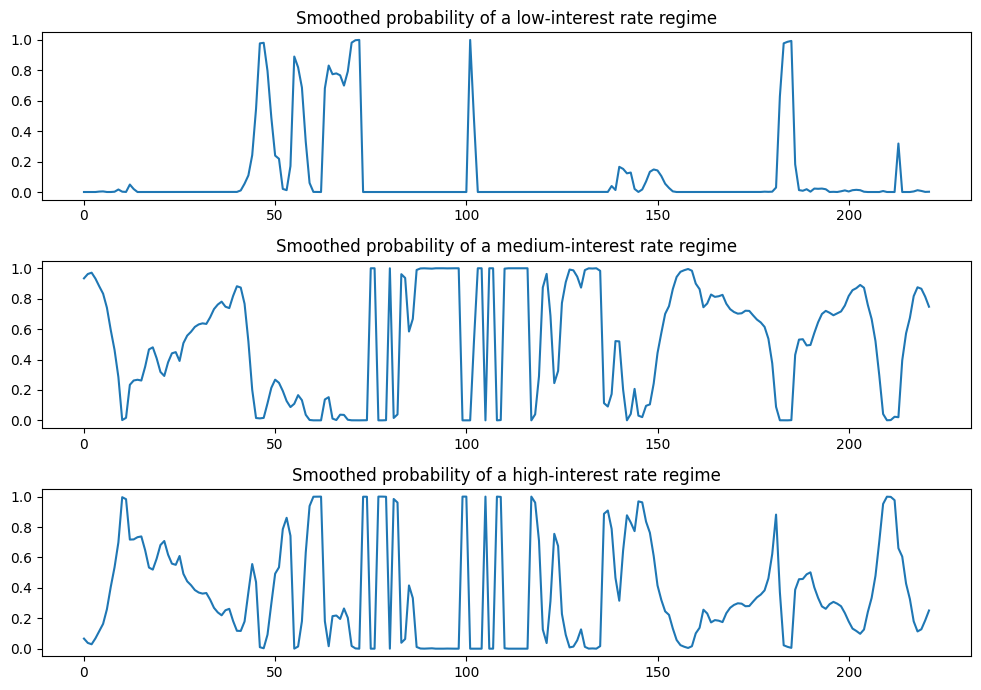

In [18]:
fig, axes = plt.subplots(3, figsize=(10, 7))

ax = axes[0]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[:, 2])
ax.set(title="Smoothed probability of a low-interest rate regime")

ax = axes[1]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[:, 0])
ax.set(title="Smoothed probability of a medium-interest rate regime")

ax = axes[2]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[:, 1])
ax.set(title="Smoothed probability of a high-interest rate regime")

fig.tight_layout()

### Switching variances

We can also accomodate switching variances. In particular, we consider the model $$y_{t} = \mu_{S_{t}} + y_{t-1}\beta_{S_t} + \varepsilon_t, \varepsilon_t \sim N(0, \sigma^2_{S_t})$$ We use maximum likelihood to estimate the parameters of this model: $$p_{00}, p_{10}, \mu_0, \mu_1, \beta_0, \beta_1, \sigma^2_0, \sigma^2_1$$

The application is to absolute returns on stocks, where the data can be found at https://www.stata-press.com/data/r14/snp500.

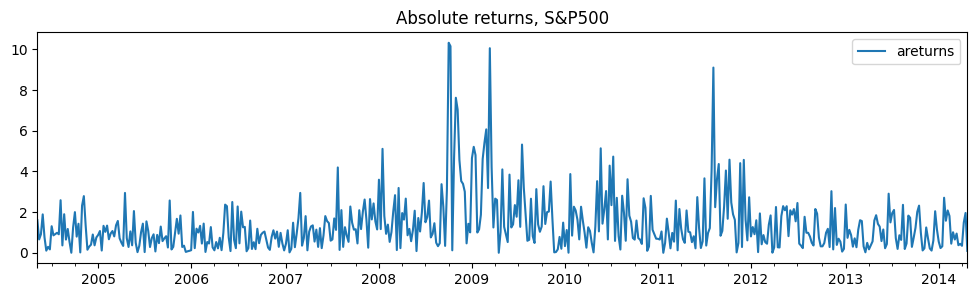

In [19]:
dta_areturns = pd.Series(
    areturns, index=pd.date_range("2004-05-04", "2014-5-03", freq="W")
, name="areturns").to_frame()
_ = dta_areturns.plot(title="Absolute returns, S&P500", figsize=(12, 3))

In [20]:
dta_areturns["lareturns"] = dta_areturns["areturns"].shift(1)
mod_areturns = regime_models.MarkovRegressionModel(data=dta_areturns.iloc[1:], 
                                         dependent_variable="areturns", 
                                         k_regimes=2, 
                                         independent_variables=["lareturns"],
                                         switching_variance=True)
res_areturns = mod_areturns.fit()

In [21]:
res_areturns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  520
Model:               MarkovRegression   Log Likelihood                -745.798
Date:                Wed, 19 Mar 2025   AIC                           1507.595
Time:                        20:12:24   BIC                           1541.626
Sample:                             0   HQIC                          1520.926
                                - 520                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7641      0.078      9.761      0.000       0.611       0.918
x1             0.0791      0.030      2.620      0.009       0.020       0.138
sigma2         0.3476      0.061      5.694      0.000       0.228       0.467
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9728      0.278      7.086      0.000       1.427       2.518
x1             0.5280      0.086      6.155      0.000       0.360       0.696
sigma2         2.5771      0.405      6.357      0.000       1.783       3.372
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7531      0.063     11.871      0.000       0.629       0.877
p[1->0]        0.6825      0.066     10.301      0.000       0.553       0.812
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

The first regime is a low-variance regime and the second regime is a high-variance regime. Below we plot the probabilities of being in the low-variance regime. Between 2008 and 2012 there does not appear to be a clear indication of one regime guiding the economy.

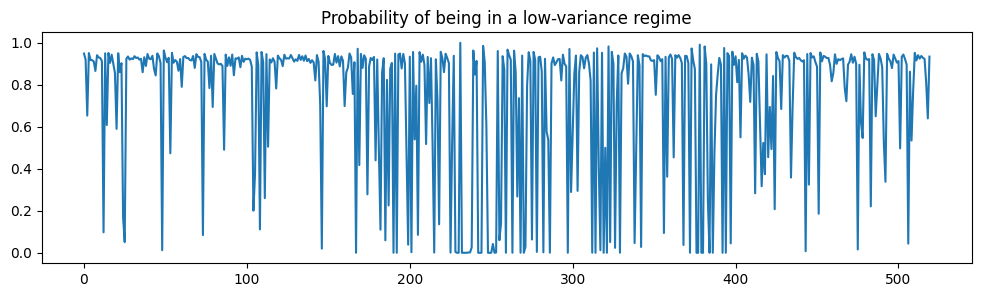

In [22]:
_ = pd.DataFrame(res_areturns.smoothed_marginal_probabilities)[0].plot(
    title="Probability of being in a low-variance regime", figsize=(12, 3)
)

***